In [2]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy

No pytransport functionality
No pytransport functionality


# Particles

In [164]:
class ParticleAnalysis():

    def __init__(self, element_type, n_sigma, length, xdim, ydim, jaw_L, bend=None, align_angle = None, line_idx= None, 
                 beam = 2, plane = 'V',
                 pot_crit = 21.34, #16 #eV Silicon
                 en_crit = 5.7e9 / 1e-2 #eV/m Silicon    #dp_Si = 1.92e-10 #m
                 ):

        self.beam = beam
        self.plane = plane
        self.element_type = element_type
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.align_angle = align_angle
        self.jaw_L = jaw_L
        self.en_crit = en_crit
        self.pot_crit = pot_crit
        self.line_idx = line_idx
        self.p0c = None
        self.npart = None
        self.data = None
        self.impact_part = None
        self.line_idx = line_idx
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None
        self.TCCS_name = 'tccs.5r3.b2'
        self.TCCP_name = 'tccp.4l3.b2'
        self.TARGET_name = 'target.4l3.b2'
        self.TCLA_name = 'tcla.a5l3.b2'
        
        if element_type == 'crystal':
            self.bend = bend 
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        return path_list   
    
    

    def load_particles(self, path, df_key = 'particles', Condor=True, file_name='particle*.h5', part_per_job = 100000):
        
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name)
            self.n_jobs = len(h5_file_path)
        else:
            default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"
            h5_file_path = default_path + path

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        i =0 
        for file in h5_file_path:
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + self.part_per_job*i    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + self.part_per_job*i
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
            i = i + 1
            
        #check if there are duplicated         
        if self.element_type == 'target':        
            data = df_particles['particle_id']
            duplicated_mask = data.duplicated()
            if len(data[duplicated_mask]) != 0:
                print(f'There are repeated particle ids: {data[duplicated_mask]}')
            
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c
        
        if self.element_type == 'crystal':
            xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
            Rcrit = self.p0c/self.en_crit
            self.xp_crit = xp_crit0*(1-Rcrit/self.bend)
            if(self.xp_crit < 0):
                print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bend} m \n!!!!!!!!!!!!!")

        
    def plot_distributions(self, x, y, px, py, **kwargs):
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
        ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
        ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        h = ax3.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax3_tw = ax3.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax3_tw.set_ylim(ax3.get_ylim()[0]/sigma_abs, ax3.get_ylim()[1]/sigma_abs)
        
        if ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 20 and ax3_tw.get_ylim()[0] - ax3_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 60 and ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax3_tw.get_ylim()[0]), np.floor(ax3_tw.get_ylim()[1]) + 1, n_ticks)
        ax3_tw.set_yticks(yticks)
        ax3_tw.set_ylabel(r' n $\sigma$')
        rect = patches.Rectangle((self.abs_x_low, self.abs_y_low), self.abs_x_up - self.abs_x_low, self.abs_y_up - self.abs_y_low, linewidth=1, edgecolor='r', facecolor='none')
        ax3.add_patch(rect)
        
        if "sigma" in kwargs and kwargs['sigma'] == True:
            ax3_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #ax3_tw.text( 0,0, r'TCP $\sigma$') #max(ax3.get_xticks())-1.5e-3, 4,

        axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax3.grid(linestyle=':')

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")
        
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        ax22.hist(py, bins=100) 
        ax22.set_xlabel(r'py [$\mu$rad]')
        ax22.set_ylabel('')
        ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        if self.element_type == 'crystal' and "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            mean_angle = None
            if self.align_angle is None and "py_mean" in kwargs:
                mean_angle = kwargs['py_mean']
            elif self.align_angle is not None:
                mean_angle = self.align_angle
            #elif "calculate_mean" in kwargs and kwargs['calculate_mean'] == True:
            #    mean_angle = self.calculate_mean_py(**kwargs)
             
            if mean_angle is not None: 
                ax22.axvline(mean_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bend} \n!!!!!!!!!!!!!")
                else:
                    ax22.axvline(mean_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax22.axvline(mean_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > mean_angle  - np.abs(self.xp_crit)) & (py < mean_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    ax22.set_title(f'N particle inside critical angle range: {chann}')

        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        #fig1.suptitle('plot')
        plt.show()
        #return fig1, [ax1,ax2,ax3]
        
        
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
        self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit)

    def compute_channeled_part(self, idx, total=None):
        df_chann = self.data[(self.data['this_turn']==self.data['at_turn']) & (self.data['at_element']==idx) &  (self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]
        chann_num = len(df_chann)
        print('Number of channeled particles over hits on crystal: ', chann_num, '/', self.npart)
        if self.n_jobs is not None:
            print(f'over a total number of particles in simulation of {self.n_jobs*self.part_per_job}')
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.TCLA_name: 1.0, self.TCCS_name: 0.004, self.TCCP_name: 0.07, self.TARGET_name: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df


    def optimize_alignment(self):

        data = self.data[['py', 'at_element']]
        min_py = data['py'].min()
        max_py = 0 # data['py'].max()
        
        n_steps = 1000
        x = np.linspace(min_py + self.xp_crit, max_py - self.xp_crit, n_steps)
        y = []
        for i in range(n_steps):
            mask = (data['py'] > x[i] - self.xp_crit) & (data['py'] < x[i] + self.xp_crit)
            y.append(len(data['py'][mask]))

        best_angle = x[y.index(max(y))]

        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'r', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'g', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        ax2.hist(data['py'], bins=100)
        ax2.set_xlabel('py [mm]')
        ax2.set_ylabel("")
        #ax2.set_yscale('log')
        ax2.axvline(best_angle, color = 'r', linestyle = '-')
        ax2.axvline(best_angle - self.xp_crit, color = 'r', linestyle = '--')
        ax2.axvline(best_angle + self.xp_crit, color = 'r', linestyle = '--')

        chann_mask = (data['py'] > self.align_angle  - np.abs(self.xp_crit)) & (data['py'] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data['py'][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        

    def optimize_POT(self, set = False):
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        
    
        best_jawL = steps[n_part.index(max(n_part))]

        fig1 = plt.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(steps, n_part)
        ax1.set_xlabel('y position [mm]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_jawL, color = 'r', linestyle = '-')
        ax1.axvline(self.jaw_L, color = 'g', linestyle = '-')

        ax3 = fig1.add_subplot(1,2,2)
        h = ax3.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax3_tw = ax3.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax3_tw.set_ylim(ax3.get_ylim()[0]/sigma_abs, ax3.get_ylim()[1]/sigma_abs)
        
        if ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 20 and ax3_tw.get_ylim()[0] - ax3_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 60 and ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax3_tw.get_ylim()[0]), np.floor(ax3_tw.get_ylim()[1]) + 1, n_ticks)
        ax3_tw.set_yticks(yticks)
        ax3_tw.set_ylabel(r' n $\sigma$')
        rect = patches.Rectangle((abs_x_low, best_jawL), abs_x_up - abs_x_low, best_jawL + self.ydim - self.abs_y_low, linewidth=1, edgecolor='r', facecolor='none')
        ax3.add_patch(rect)


        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

#### IR7 IR3 rematched 

7.2

ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, jaw_L=0.00271382348186472, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009926466680130504, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=44.0, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.009926888089125938, line_idx=110987)

7.7

ParticleAnalysis(element_type='crystal', n_sigma=8.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=44.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.010129508044042264, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=44.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.01012993807276715, line_idx=110987)

8.2

ParticleAnalysis(element_type='crystal', n_sigma=7.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.4995650450998158e-05, jaw_L=0.0029022834458831037, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.007580210919372385, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=33.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007580532722605261, line_idx=110987)

8.7

?

#### IR7 rematched 

7.7

ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.4117809785569858e-05, jaw_L=0.0020239975348699253, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=32.2, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009891648511984007, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=32.2, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.00989218276655034, line_idx=110987)

7.7

?

8.2

ParticleAnalysis(element_type='crystal', n_sigma=8.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.6618744636127907e-05, jaw_L=0.003090743409901487, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=34.3, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.007738131980192642, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=34.3, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007738460487659537, line_idx=110987)


8.7

ParticleAnalysis(element_type='crystal', n_sigma=8.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=34.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.0078058124348298966, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=34.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007806143815539942, line_idx=110987)

In [ ]:
IR3_IR7rem_TCCS_7_2 = 'TEST_IR7_IR3_rem_TCCS_7.2__target_absorber_20240219-1112'

In [165]:
TCCS_IR3_IR7_7_2 = ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, jaw_L=0.00271382348186472, line_idx=110029)
TARGET_IR3_IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009926466680130504, line_idx=110984)

In [166]:
TCCS_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TARGET_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="TARGET_impacts") 

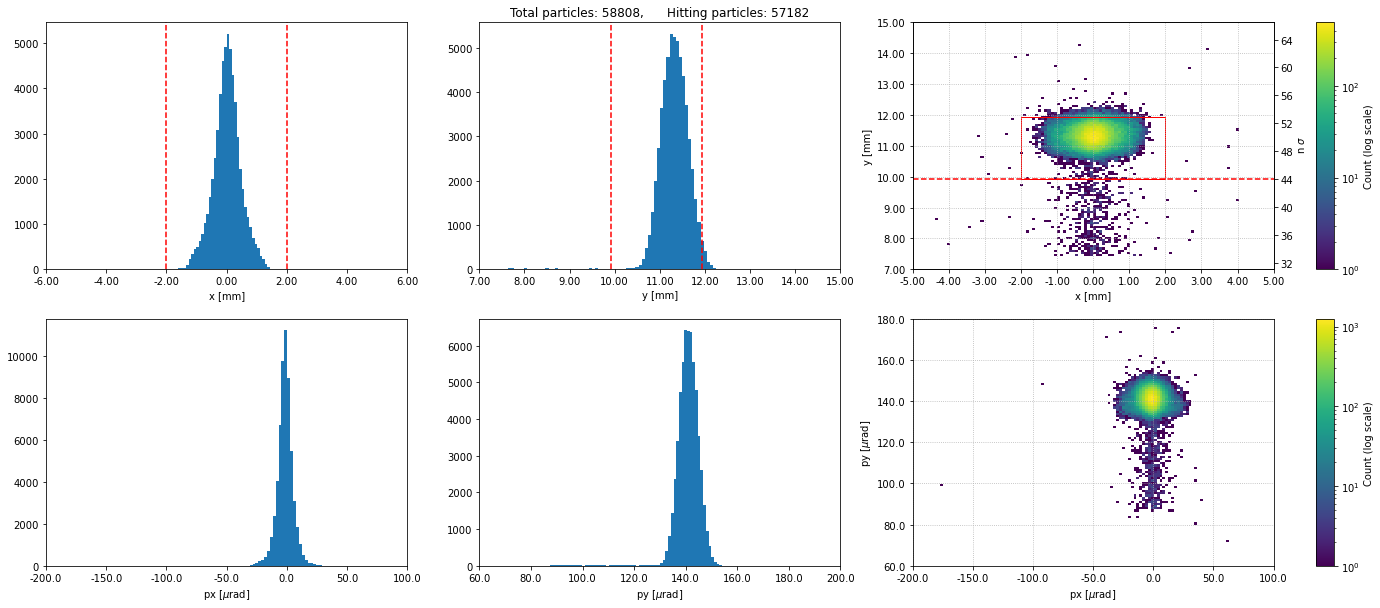

In [167]:
TARGET_IR3_IR7_7_2.compute_impact_particles(sigma=True)

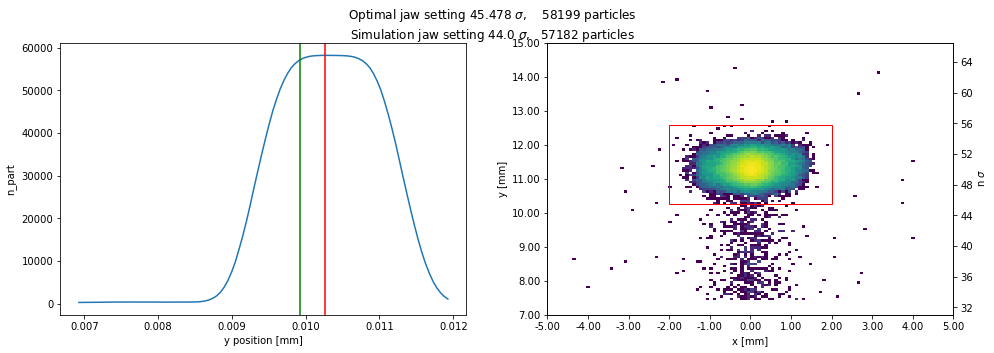

In [171]:
TARGET_IR3_IR7_7_2.optimize_POT(set=True)

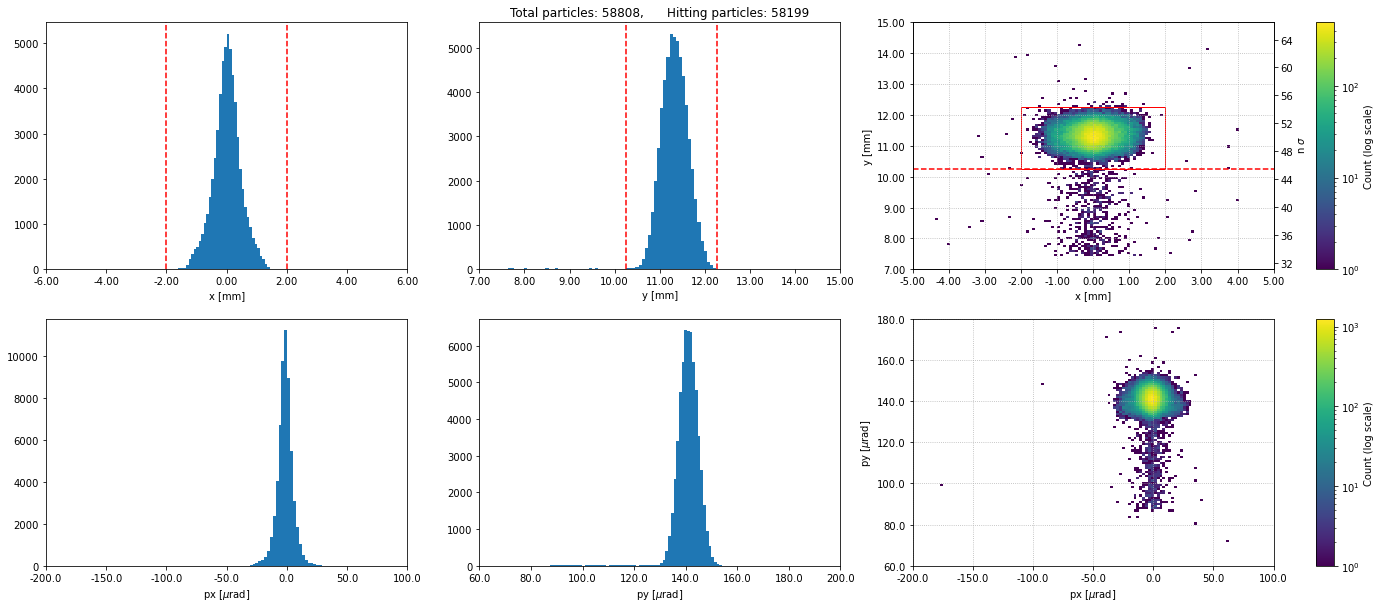

In [172]:
TARGET_IR3_IR7_7_2.compute_impact_particles(sigma=True)

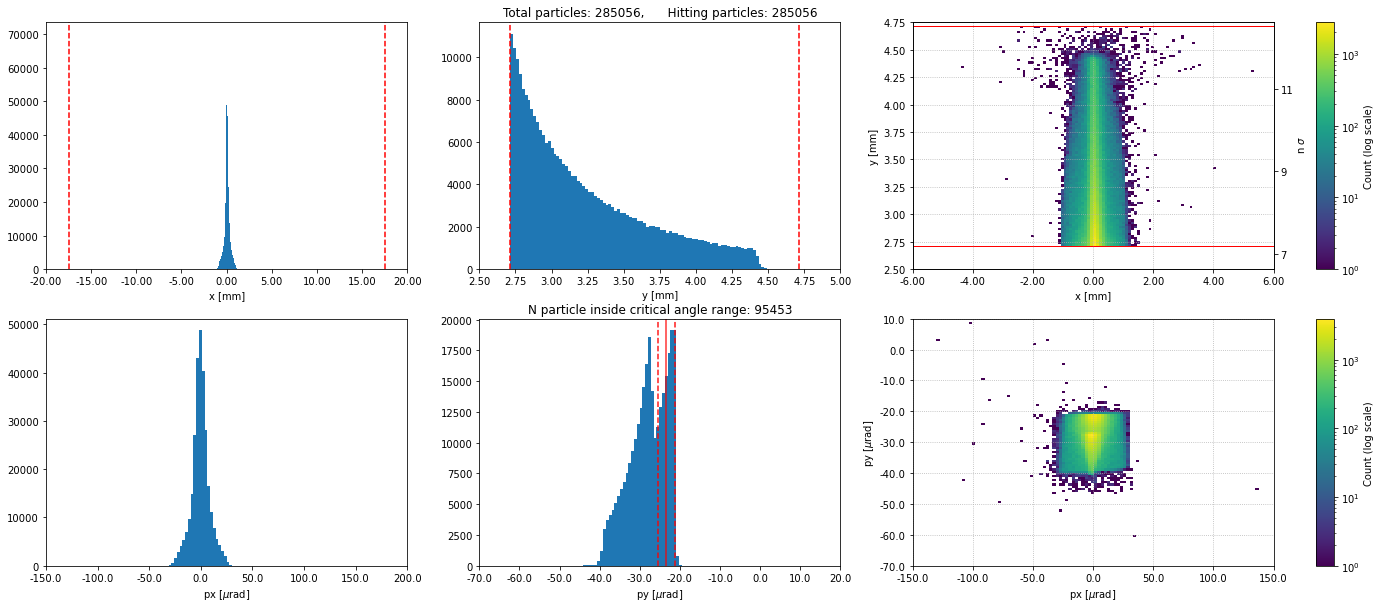

In [173]:
TCCS_IR3_IR7_7_2.compute_impact_particles(xpcrit=True)

In [174]:
TCCS_IR3_IR7_7_2.compute_channeled_part(TARGET_IR3_IR7_7_2.line_idx)

Number of channeled particles over hits on crystal:  58257 / 285056
over a total number of particles in simulation of 10000000


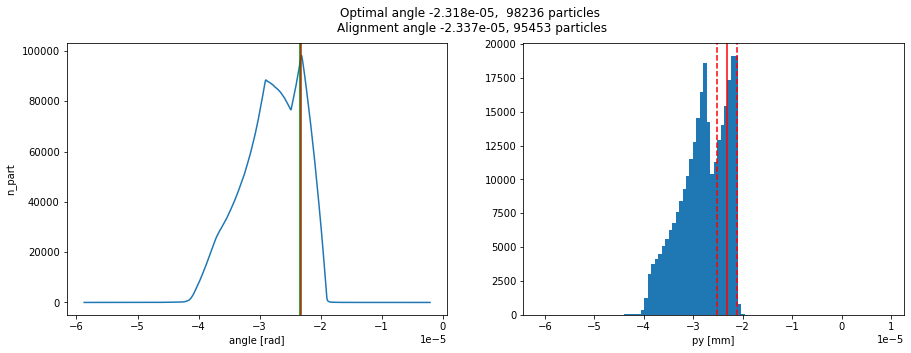

In [175]:
TCCS_IR3_IR7_7_2.optimize_alignment()

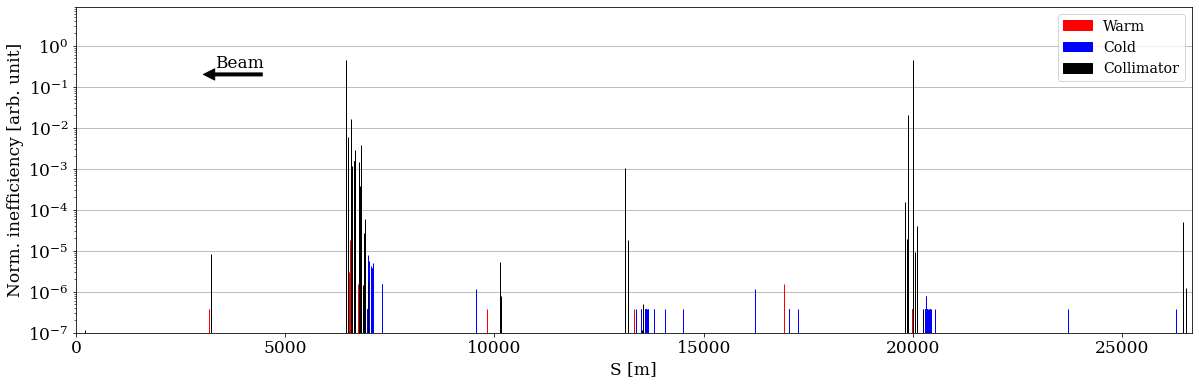

In [176]:
TARGET_IR3_IR7_7_2.load_lossmap(IR3_IR7rem_TCCS_7_2, zoom=False)

In [13]:
TARGET_IR3_IR7_7_2.compute_losses()

,s,name,losses_type,losses,length,npart
5,6459.742798,tcp.d6r7.b2,Losses.COLL,11951335.0,0.600,7170801.0
1044,19885.183171,tccs.5r3.b2,Losses.COLL,539750.0,0.004,2159.0
1049,20005.545671,target.4l3.b2,Losses.COLL,11667200.0,0.005,58336.0
1053,20084.662376,tcla.a5l3.b2,Losses.COLL,1050.0,1.000,1050.0


(array([6.9100e+02, 1.2130e+03, 2.3000e+02, 7.1000e+01, 9.3300e+02,
        1.1267e+04, 1.6600e+02, 8.0200e+03, 8.8300e+02, 6.7600e+02,
        2.2600e+02, 5.3400e+02, 8.7100e+03, 2.1500e+02, 1.8340e+03,
        7.9100e+02, 9.2600e+02, 7.6000e+01, 2.6250e+03, 2.3410e+03,
        1.5900e+02, 2.9300e+02, 1.6200e+02, 3.7000e+02, 2.5000e+01,
        3.1120e+03, 6.6700e+02, 2.0400e+02, 9.2000e+01, 1.6100e+02,
        6.5700e+02, 2.8000e+01, 1.2620e+03, 2.5100e+02, 9.9000e+01,
        4.8000e+01, 1.2700e+02, 1.3340e+03, 3.5000e+01, 3.6200e+02,
        9.6000e+01, 1.0100e+02, 1.4000e+01, 2.4700e+02, 8.7400e+02,
        1.9000e+01, 2.1900e+02, 3.7000e+01, 1.2500e+02, 1.2000e+01,
        7.2100e+02, 2.7300e+02, 5.7000e+01, 3.0000e+01, 4.4000e+01,
        1.2100e+02, 6.0000e+00, 1.0790e+03, 1.3700e+02, 1.1900e+02,
        2.9000e+01, 1.3200e+02, 5.3900e+02, 1.1000e+01, 3.3600e+02,
        3.8000e+01, 2.7000e+01, 8.0000e+00, 4.2000e+01, 2.9100e+02,
        1.3000e+01, 5.1000e+01, 5.1000e+01, 6.40

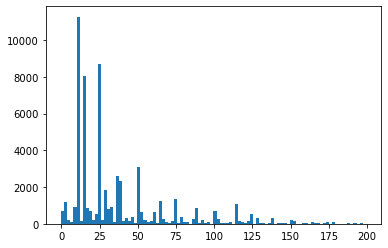

In [17]:
plt.hist(TARGET_IR3_IR7_7_2.data['at_turn'], bins=100)

# IR7 REMATCHED"

In [178]:
IR7rem_TCCS_7_2 = 'TEST_IR7_rem_TCCS_7.2__target_absorber_20240220-0926'

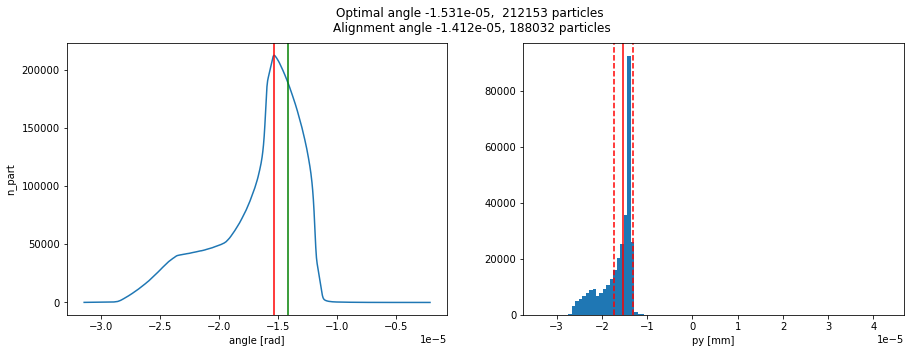

In [180]:
TCCS_IR7_7_2 = ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.4117809785569858e-05, jaw_L=0.0020239975348699253, line_idx=110029)
TCCS_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TCCS_IR7_7_2.optimize_alignment()


In [181]:
TARGET_IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.010321720186418094, line_idx=110984)
TARGET_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TARGET_impacts") 

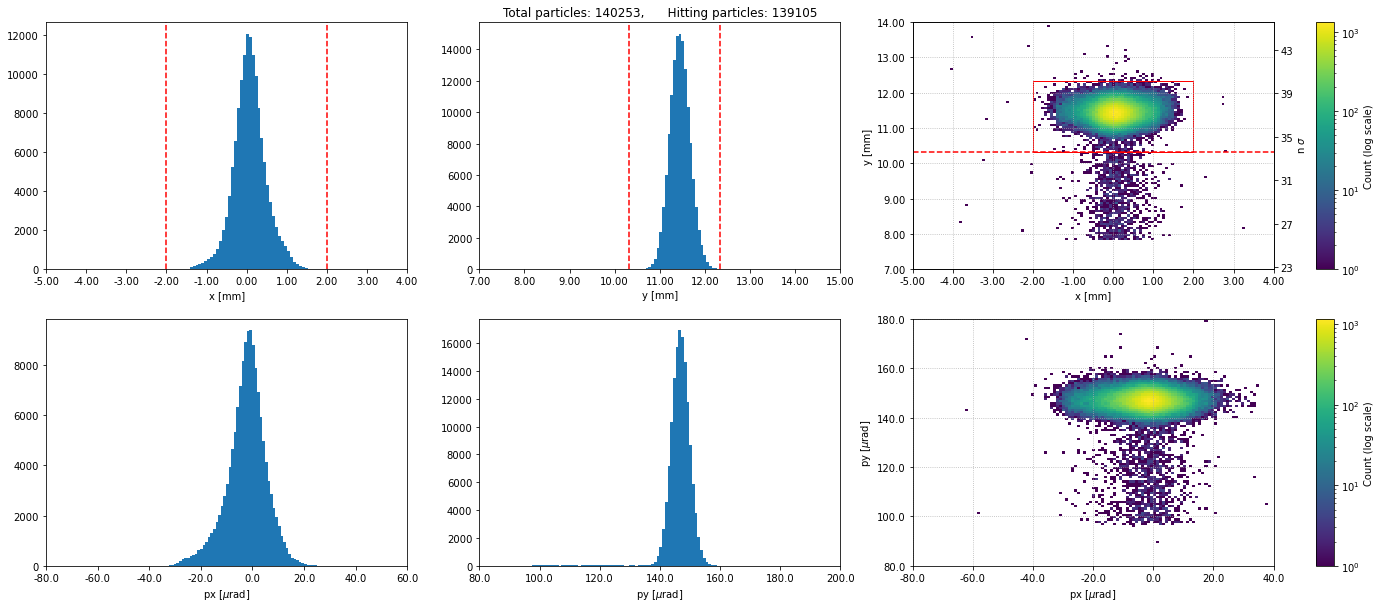

In [182]:
TARGET_IR7_7_2.compute_impact_particles(sigma=True)

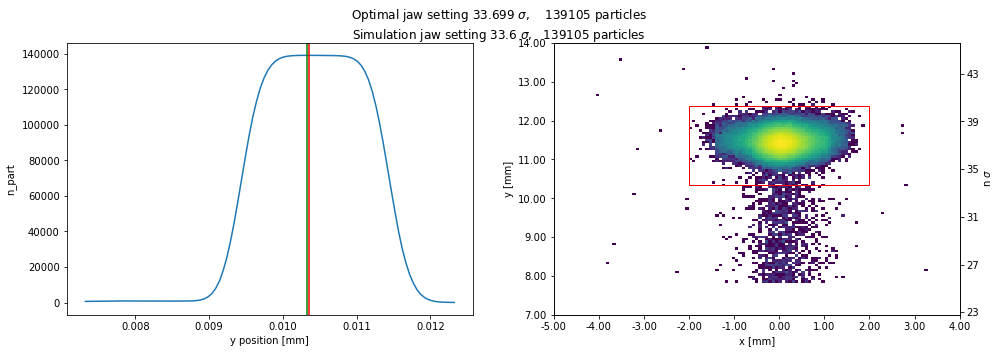

In [185]:
TARGET_IR7_7_2.optimize_POT(set=True)

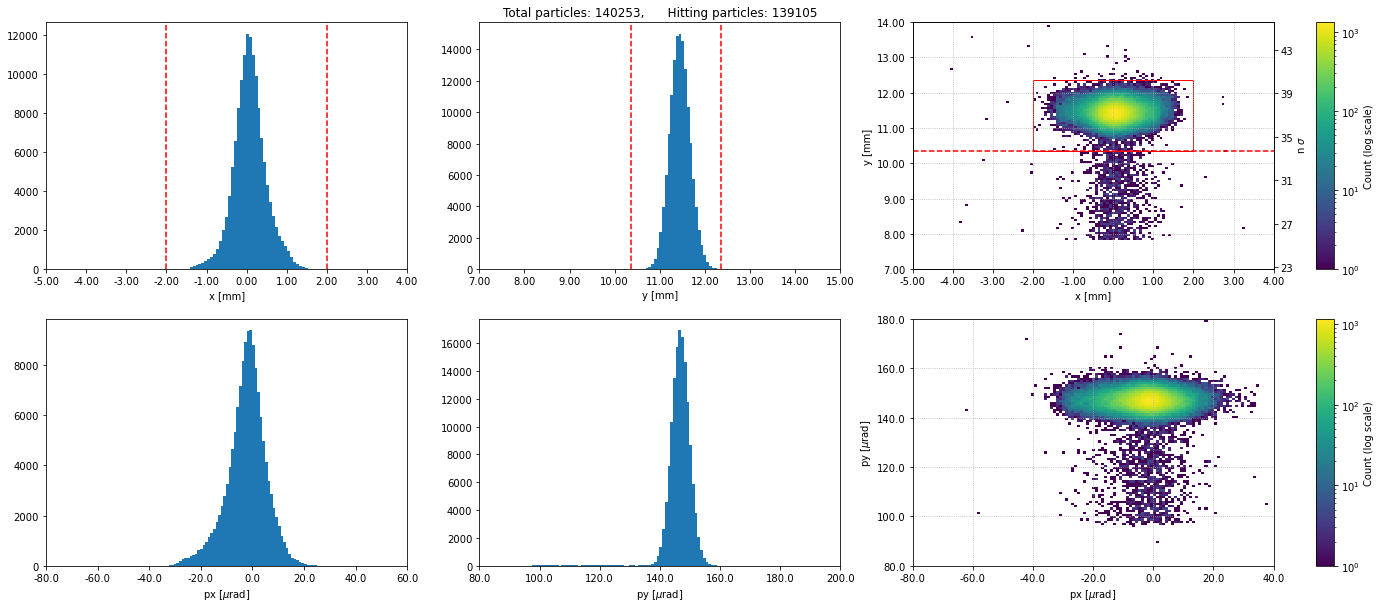

In [186]:
TARGET_IR7_7_2.compute_impact_particles(sigma=True)

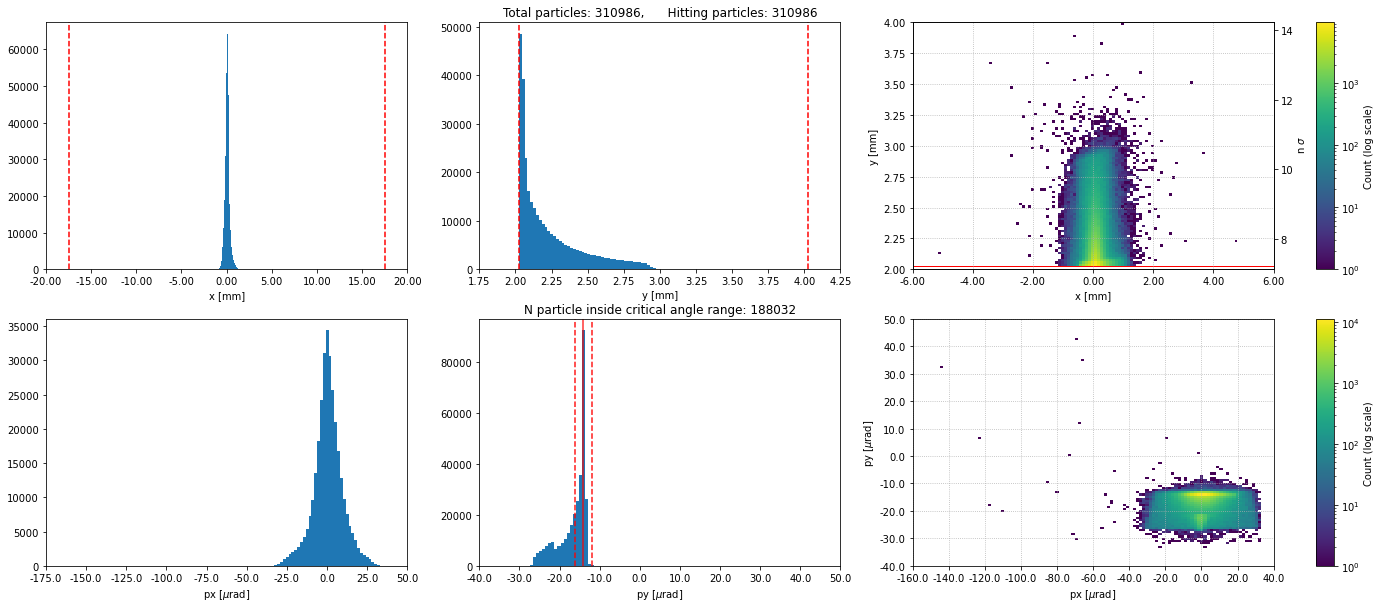

In [32]:
TCCS_IR7_7_2.compute_impact_particles(xpcrit=True)

pymadx.Tfs.Load> normal file


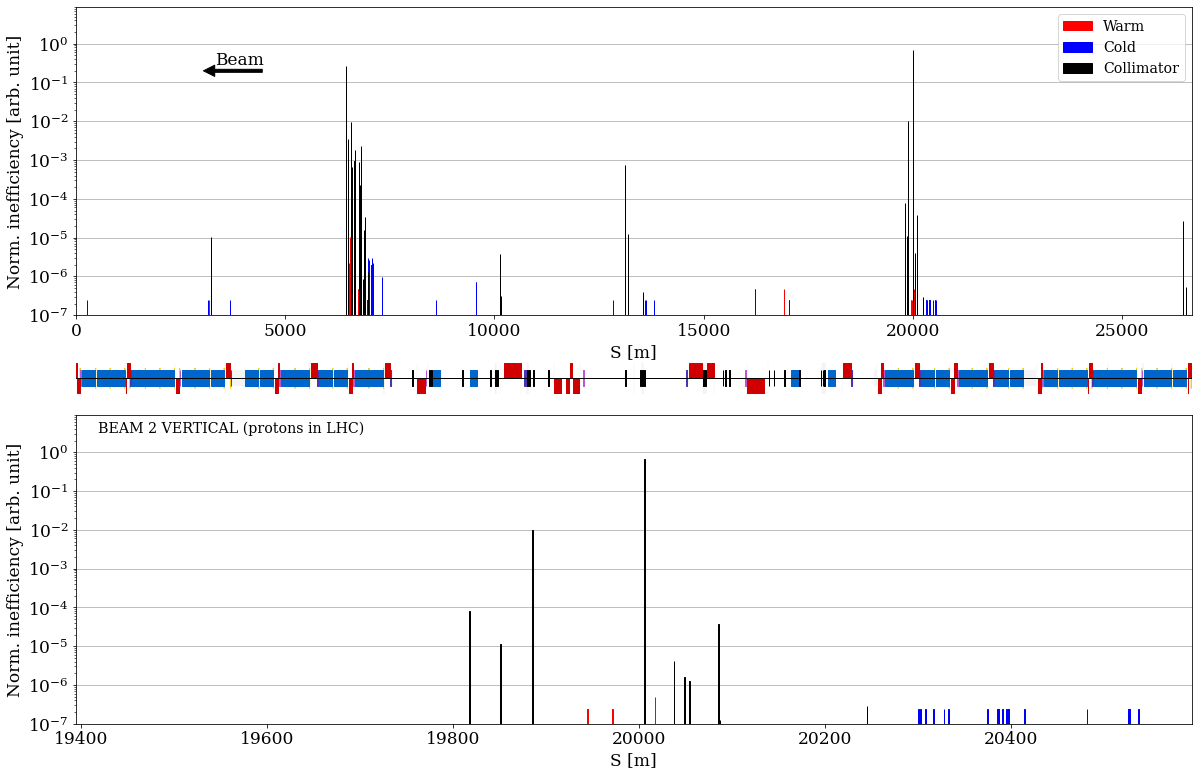

In [39]:
TARGET_IR7_7_2.load_lossmap(IR7rem_TCCS_7_2, zoom=False)


In [34]:
TARGET_IR7_7_2.compute_losses()

,s,name,losses_type,losses,length,npart
8,6459.742798,tcp.d6r7.b2,Losses.COLL,11229100.0,0.600,6737460.0
1024,19885.183171,tccs.5r3.b2,Losses.COLL,418250.0,0.004,1673.0
1028,20005.545671,target.4l3.b2,Losses.COLL,27837200.0,0.005,139186.0
1033,20084.662376,tcla.a5l3.b2,Losses.COLL,1584.0,1.000,1584.0


In [35]:
TCCS_IR7_7_2.compute_channeled_part(TARGET_IR7_7_2.line_idx)

Number of channeled particles over hits on crystal:  138708 / 310986
over a total number of particles in simulation of 10000000


In [ ]:
IR7rem_TCCS_7_7 = 'TEST_IR7_rem_TCCS_7.7__target_absorber'

In [ ]:
TCCS_IR7_7_7 = 
TARGET_IR7_7_7 =

In [ ]:
IR7rem_TCCS_8_2 = 'TEST_IR7_rem_TCCS_8.2__target_absorber'

In [ ]:
TCCS_IR7_8_2 = 
TARGET_IR7_8_2 =

In [ ]:
IR7rem_TCCS_8_7 = 'TEST_IR7_rem_TCCS_8.7__target_absorber'

In [ ]:
TCCS_IR7_8_7 = 
TARGET_IR7_8_7 =